# EEG Analysis: Across Blocks

In this notebook, we examine changes of ratios measures and spectral parameters across blocks. 

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('talk')

In [2]:
# Import custom project code
import sys
sys.path.append('../bratios')
from bootstrap import bootstrap_corr, bootstrap_diff
from plot import plot_scatter
from analysis import calculate_diffs, average_df, nan_corr_spearman
from utils import print_stat

from paths import DATA_PATHS as dp
from paths import FIGS_PATHS as fp

## Settings

In [3]:
# Settings
SAVE_FIG = False
PROCESS_DATA = False   # If False, reload previously processed & saved data

In [4]:
# Set values for analyses
N_BLOCKS = 5
RATIOS = ['TBR', 'TAR', 'ABR']
CORR_FUNC = nan_corr_spearman

In [5]:
# Set random seed
np.random.seed(53)

## Data Setup

In [6]:
# Read datafile with dataset information
data = pd.read_csv(dp.make_file_path(dp.eeg_meta, 'MIPDB_PublicFile', 'csv'))

In [7]:
# Set a list of all channel indices
all_chans = np.arange(0, 111)

In [8]:
# Get the dataframes of the measures, per block
dfs = []
if PROCESS_DATA:
    
    for ind in range(0, N_BLOCKS):
        df = get_all_data(data, all_chans, ind, verbose=True)
        dfs.append(df)   
    
    # Save out dataframes
    for ind, df in enumerate(dfs):
        file_name = dp.make_file_path(\
            dp.eeg_outputs, 'block_{}_measures'.format(ind+1), 'csv')
        df.to_csv(file_name, index=False)

else:
    # Reload the dataframes
    for ind in range(N_BLOCKS):
        dfs.append(pd.read_csv(dp.make_file_path(\
            dp.eeg_outputs, 'block_{}_measures'.format(ind+1), 'csv')))

In [9]:
# Check out the dataframe
dfs[0].head()

,ABR,Age,Alpha_BW,Alpha_CF,Alpha_PW,Beta_BW,Beta_CF,Beta_PW,Chan_ID,Exp,Off,Subj_ID,TAR,TBR,Theta_BW,Theta_CF,Theta_PW,fit_error,fit_n_peaks,fit_r2
0,7.813890,10.0,2.576703,10.435449,0.632868,1.000000,21.527200,0.400035,0.0,1.861028,1.198543,A00051826,1.910381,14.927507,2.465467,7.168887,0.620085,0.059703,6.0,0.985572
1,6.434886,10.0,2.486382,10.419302,0.437829,1.000000,21.621280,0.398605,1.0,1.921815,1.667305,A00051826,2.560303,16.475258,2.423633,7.288577,0.636508,0.075356,5.0,0.981487
2,7.159705,10.0,3.150005,10.162053,0.562540,1.561147,23.902277,0.436887,2.0,1.928513,1.440073,A00051826,2.345069,16.790004,1.000000,7.672382,0.571536,0.062042,8.0,0.986960
3,7.314351,10.0,3.084489,10.129110,0.540996,1.116480,23.754128,0.321801,3.0,1.994309,1.536305,A00051826,2.292491,16.768082,1.292295,6.405735,0.463977,0.060083,8.0,0.987369
4,8.363157,10.0,2.866701,10.214234,0.534867,1.000000,23.822393,0.201616,4.0,2.035492,1.621442,A00051826,2.600753,21.750502,1.917561,6.829388,0.514026,0.077565,4.0,0.982238


## Check Correlations Across Blocks

First, check the consistency of the correlations between ratios and parameters, calculated across each block. 

Exploring across blocks and parameters, we see the relationships are very stable. 

In [10]:
# Set parameter to compare against
param = 'Exp'

In [11]:
# Check correlations between parameters across trials
block_corrs = {}
for ratio in RATIOS:
    corrs = []
    for cur_df in dfs:
        corrs.append(nan_corr_spearman(cur_df[param], cur_df[ratio])[0])
    block_corrs[ratio] = np.array(corrs)

In [12]:
print('Correlations across blocks')
for ratio in RATIOS:
    with np.printoptions(precision=3, suppress=True):
        print('  ', ratio, ': ', block_corrs[ratio])

Correlations across blocks
   TBR :  [0.745 0.704 0.683 0.714 0.674]
   TAR :  [0.208 0.244 0.214 0.21  0.248]
   ABR :  [0.347 0.343 0.311 0.395 0.273]


## Calculate Difference Measures

Calculate difference measures across block, calculated for each measure and `val[block] - val[block-1]`. 

This lets us explore the within subject dynamics of different measures, and how they relate to each other.

In [13]:
# Calculate differences across block of each measure
diffs = calculate_diffs(dfs, all_chans)

In [14]:
# Check correlations between difference measures
print('Correlations between difference measures:')
print_stat('Exp & Theta-PW', *bootstrap_corr(diffs['Exp'], diffs['Theta_PW'], func=CORR_FUNC))
print_stat('Exp & Alpha-PW', *bootstrap_corr(diffs['Exp'], diffs['Alpha_PW'], func=CORR_FUNC))
print_stat('Exp & Beta-PW ', *bootstrap_corr(diffs['Exp'], diffs['Beta_PW'], func=CORR_FUNC))

Correlations between difference measures:
	 Exp & Theta-PW 	 +0.0018    [-0.0960, +0.0999]    0.9704
	 Exp & Alpha-PW 	 -0.0268    [-0.1283, +0.0786]    0.5767
	 Exp & Beta-PW  	 +0.1538    [+0.0541, +0.2498]    0.0013


### theta / beta ratio

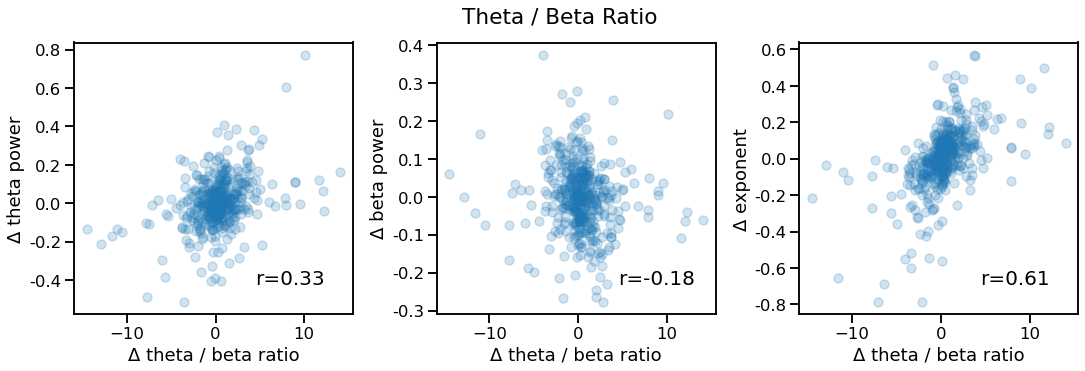

In [15]:
# Plot the relation between difference measures for TBR
_, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle('Theta / Beta Ratio')
plot_scatter(diffs['TBR'], diffs['Theta_PW'], ax=axes[0], 
             xlabel='Δ theta / beta ratio', ylabel='Δ theta power')
plot_scatter(diffs['TBR'], diffs['Beta_PW'], ax=axes[1], 
             xlabel='Δ theta / beta ratio', ylabel='Δ beta power')
plot_scatter(diffs['TBR'], diffs['Exp'], ax=axes[2],
             xlabel='Δ theta / beta ratio', ylabel='Δ exponent')
plt.subplots_adjust(wspace = 0.3)
if SAVE_FIG:
    plt.savefig(fp.make_file_path(fp.eeg_blocks, 'blocks_tbr', 'pdf'),
                bbox_inches='tight')

In [16]:
# Calculate correlations between difference measures for TBR
print('TBR - Within Subj Diffs:')
print_stat('TBR & Theta', *bootstrap_corr(diffs['TBR'], diffs['Theta_PW'], func=CORR_FUNC))
print_stat('TBR & Beta', *bootstrap_corr(diffs['TBR'], diffs['Beta_PW'], func=CORR_FUNC))
print_stat('TBR & EXP', *bootstrap_corr(diffs['TBR'], diffs['Exp'], func=CORR_FUNC))

TBR - Within Subj Diffs:
	 TBR & Theta 	 +0.3296    [+0.2339, +0.4165]    0.0000
	 TBR & Beta 	 -0.1776    [-0.2688, -0.0808]    0.0002
	 TBR & EXP 	 +0.6077    [+0.5426, +0.6671]    0.0000


In [17]:
# Check differences between correlations for the TBR
print('TBR - Differences between correlations:')
print_stat('AP-Exp vs. Theta PW',
           *bootstrap_diff(diffs['TBR'], diffs['Exp'], diffs['Theta_PW'], 
                           func=CORR_FUNC, absolute=True))
print_stat('AP-Exp vs. Beta PW',
           *bootstrap_diff(diffs['TBR'], diffs['Exp'], diffs['Beta_PW'], 
                           func=CORR_FUNC, absolute=True))
print_stat('Theta PW vs. Beta PW',
           *bootstrap_diff(diffs['TAR'], diffs['Theta_PW'], diffs['Beta_PW'], 
                           func=CORR_FUNC, absolute=True))

TBR - Differences between correlations:
	 AP-Exp vs. Theta PW 	 +0.2781    [+0.1600, +0.3926]    0.0000
	 AP-Exp vs. Beta PW 	 +0.4300    [+0.3041, +0.5505]    0.0000
	 Theta PW vs. Beta PW 	 -0.1241    [-0.2685, +0.0181]    0.0804


### theta / alpha ratio

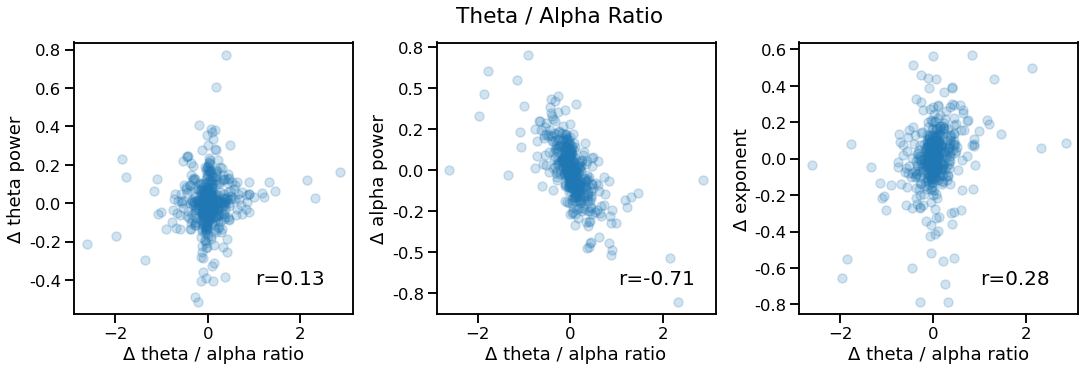

In [18]:
# Plot the relation between difference measures for TAR
_, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle('Theta / Alpha Ratio')
plot_scatter(diffs['TAR'], diffs['Theta_PW'], ax=axes[0], 
             xlabel='Δ theta / alpha ratio', ylabel='Δ theta power')
plot_scatter(diffs['TAR'], diffs['Alpha_PW'], ax=axes[1], 
             xlabel='Δ theta / alpha ratio', ylabel='Δ alpha power')
plot_scatter(diffs['TAR'], diffs['Exp'], ax=axes[2],
             xlabel='Δ theta / alpha ratio', ylabel='Δ exponent')
plt.subplots_adjust(wspace = 0.3)
if SAVE_FIG:
    plt.savefig(fp.make_file_path(fp.eeg_blocks, 'blocks_tar', 'pdf'),
                bbox_inches='tight')

In [19]:
# Calculate correlations between difference measures for TAR
print('TAR - Within Subj Diffs:')
print_stat('TAR & Theta', *bootstrap_corr(diffs['TAR'], diffs['Theta_PW'], func=CORR_FUNC))
print_stat('TAR & Alpha', *bootstrap_corr(diffs['TAR'], diffs['Alpha_PW'], func=CORR_FUNC))
print_stat('TAR & EXP', *bootstrap_corr(diffs['TAR'], diffs['Exp'], func=CORR_FUNC))

TAR - Within Subj Diffs:
	 TAR & Theta 	 +0.1277    [+0.0366, +0.2157]    0.0079
	 TAR & Alpha 	 -0.7052    [-0.7559, -0.6460]    0.0000
	 TAR & EXP 	 +0.2821    [+0.1873, +0.3777]    0.0000


In [20]:
# Check differences between correlations for the TAR
print('TAR - Differences between correlations:')
print_stat('AP-Exp vs. Theta PW',
           *bootstrap_diff(diffs['TAR'], diffs['Exp'], diffs['Theta_PW'], 
                           func=CORR_FUNC, absolute=True))
print_stat('AP-Exp vs. Alpha PW',
           *bootstrap_diff(diffs['TAR'], diffs['Exp'], diffs['Alpha_PW'], 
                           func=CORR_FUNC, absolute=True))
print_stat('Theta PW vs. Alpha PW',
           *bootstrap_diff(diffs['TAR'], diffs['Theta_PW'], diffs['Alpha_PW'], 
                           func=CORR_FUNC, absolute=True))

TAR - Differences between correlations:
	 AP-Exp vs. Theta PW 	 +0.1544    [+0.0267, +0.2892]    0.0220
	 AP-Exp vs. Alpha PW 	 -0.4231    [-0.5352, -0.3097]    0.0000
	 Theta PW vs. Alpha PW 	 -0.5774    [-0.6897, -0.4601]    0.0000


### alpha / beta ratio

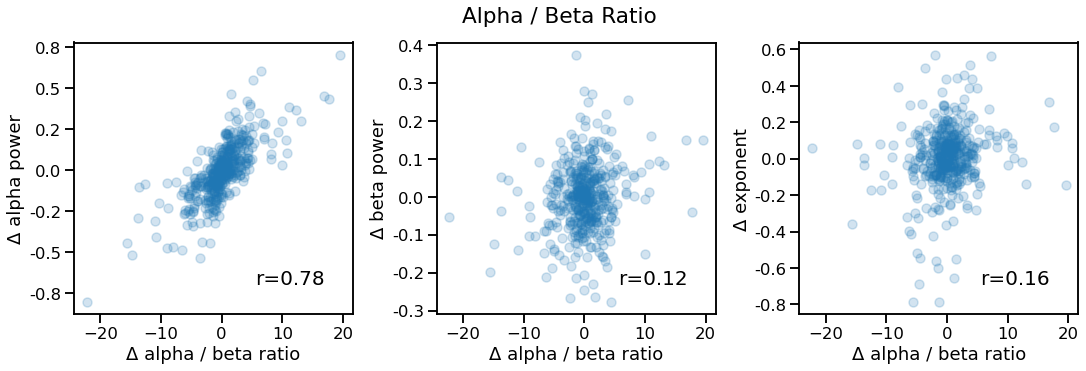

In [21]:
# Plot the relation between difference measures for ABR
_, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle('Alpha / Beta Ratio')
plot_scatter(diffs['ABR'], diffs['Alpha_PW'], ax=axes[0], 
             xlabel='Δ alpha / beta ratio', ylabel='Δ alpha power')
plot_scatter(diffs['ABR'], diffs['Beta_PW'], ax=axes[1], 
             xlabel='Δ alpha / beta ratio', ylabel='Δ beta power')
plot_scatter(diffs['ABR'], diffs['Exp'], ax=axes[2],
             xlabel='Δ alpha / beta ratio', ylabel='Δ exponent')
plt.subplots_adjust(wspace = 0.3)
if SAVE_FIG:
    plt.savefig(fp.make_file_path(fp.eeg_blocks, 'blocks_abr', 'pdf'),
                bbox_inches='tight')

In [22]:
# Calculate correlations between difference measures for ABR
print('ABR - Within Subj Diffs:')
print_stat('ABR & Alpha', *bootstrap_corr(diffs['ABR'], diffs['Alpha_PW'], func=CORR_FUNC))
print_stat('ABR & Beta', *bootstrap_corr(diffs['ABR'], diffs['Beta_PW'], func=CORR_FUNC))
print_stat('ABR & EXP', *bootstrap_corr(diffs['ABR'], diffs['Exp'], func=CORR_FUNC))

ABR - Within Subj Diffs:
	 ABR & Alpha 	 +0.7762    [+0.7332, +0.8126]    0.0000
	 ABR & Beta 	 +0.1186    [+0.0193, +0.2166]    0.0132
	 ABR & EXP 	 +0.1599    [+0.0633, +0.2531]    0.0008


In [23]:
# Check differences between correlations for the ABR
print('ABR - Differences between correlations:')
print_stat('AP-Exp vs. Alpha PW',
           *bootstrap_diff(diffs['ABR'], diffs['Exp'], diffs['Alpha_PW'], 
                           func=CORR_FUNC, absolute=True))
print_stat('AP-Exp vs. Beta PW',
           *bootstrap_diff(diffs['ABR'], diffs['Exp'], diffs['Beta_PW'], 
                           func=CORR_FUNC, absolute=True))
print_stat('Alpha PW vs. Beta PW',
           *bootstrap_diff(diffs['TAR'], diffs['Alpha_PW'], diffs['Beta_PW'], 
                           func=CORR_FUNC, absolute=True))

ABR - Differences between correlations:
	 AP-Exp vs. Alpha PW 	 -0.6163    [-0.7222, -0.5119]    0.0000
	 AP-Exp vs. Beta PW 	 +0.0413    [-0.0806, +0.1639]    0.5044
	 Alpha PW vs. Beta PW 	 +0.4533    [+0.3565, +0.5495]    0.0000


## Plot all together

This creates the full plot, which the same as the three panels above, all collected together.

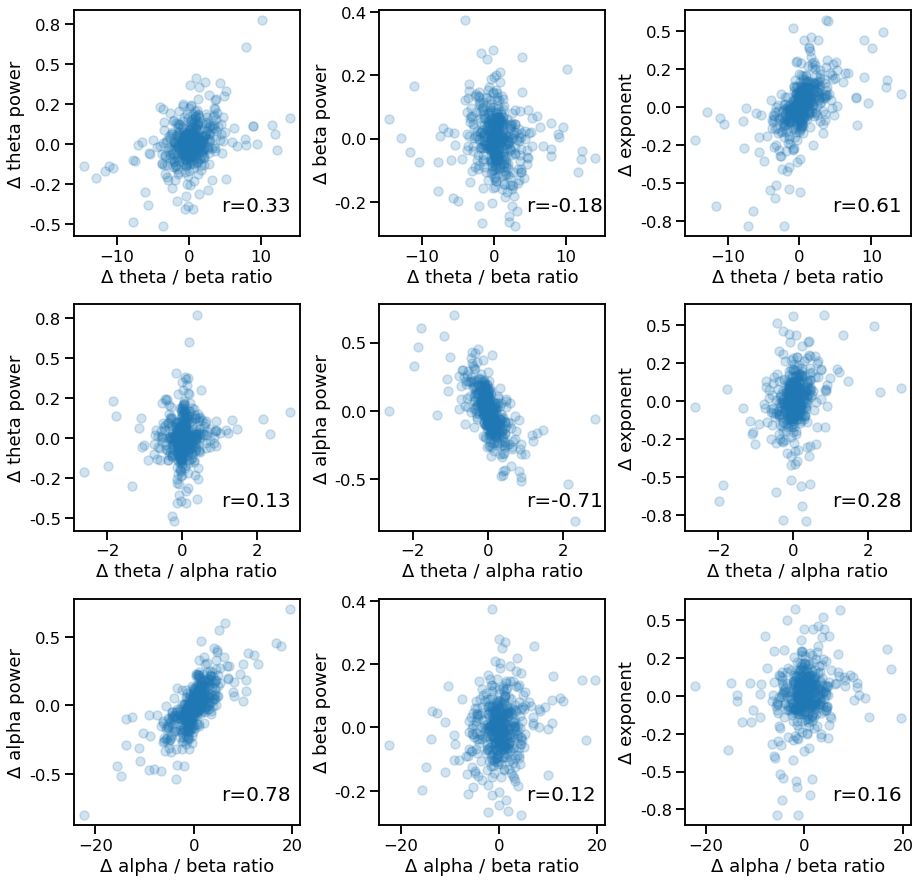

In [24]:
# Plot the combined figure
_, axes = plt.subplots(3, 3, figsize=(15, 15))

plot_scatter(diffs['TBR'], diffs['Theta_PW'], ax=axes[0][0], 
             xlabel='Δ theta / beta ratio', ylabel='Δ theta power')
plot_scatter(diffs['TBR'], diffs['Beta_PW'], ax=axes[0][1], 
             xlabel='Δ theta / beta ratio', ylabel='Δ beta power')
plot_scatter(diffs['TBR'], diffs['Exp'], ax=axes[0][2],
             xlabel='Δ theta / beta ratio', ylabel='Δ exponent')

plot_scatter(diffs['TAR'], diffs['Theta_PW'], ax=axes[1][0], 
             xlabel='Δ theta / alpha ratio', ylabel='Δ theta power')
plot_scatter(diffs['TAR'], diffs['Alpha_PW'], ax=axes[1][1], 
             xlabel='Δ theta / alpha ratio', ylabel='Δ alpha power')
plot_scatter(diffs['TAR'], diffs['Exp'], ax=axes[1][2],
             xlabel='Δ theta / alpha ratio', ylabel='Δ exponent')

plot_scatter(diffs['ABR'], diffs['Alpha_PW'], ax=axes[2][0], 
             xlabel='Δ alpha / beta ratio', ylabel='Δ alpha power')
plot_scatter(diffs['ABR'], diffs['Beta_PW'], ax=axes[2][1], 
             xlabel='Δ alpha / beta ratio', ylabel='Δ beta power')
plot_scatter(diffs['ABR'], diffs['Exp'], ax=axes[2][2],
             xlabel='Δ alpha / beta ratio', ylabel='Δ exponent')

plt.subplots_adjust(hspace=0.3, wspace = 0.35)
if SAVE_FIG:
    plt.savefig(fp.make_file_path(fp.eeg_blocks, 'blocks_all', 'pdf'),
                bbox_inches='tight')

## Extra / Control Analyses

Words, words, words.

In [25]:
# Create average dataframes - averaged across all channels
avg_dfs = []
for df in dfs:
    avg_dfs.append(average_df(df, all_chans))

# Get list of subject numbers
subjs = list(avg_dfs[-1].index)

### Check Within Subject Correlations

As an additional analysis, check the correlation between parameters, within subjects.

For this analysis, we get the measures per subject, per block, and calculate the correlation within subjects. 

We can then check the distribution of correlations within subjects.

In [26]:
# Set which ratio & parameter to run
ratio = 'TBR'
param = 'Exp'

In [27]:
# Calculate the correlation between measures, within each subject
corrs = []
for subj in subjs:
    
    ratio_temp = []
    param_temp = []
    
    for df in avg_dfs:
        ratio_temp.append(df.loc[subj][ratio])
        param_temp.append(df.loc[subj][param])

    corrs.append(CORR_FUNC(ratio_temp, param_temp)[0])

In [28]:
# Check average correlation
print('Average within subject correlation: {:1.2f}'.format(np.median(corrs)))

Average within subject correlation: 0.70


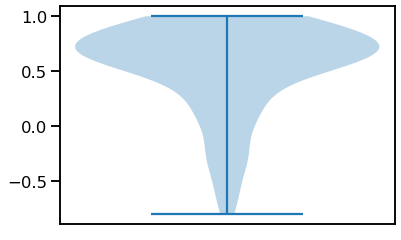

In [29]:
# Plot distribution of within subject correlations
plt.violinplot(corrs);
plt.xticks([]);

### Check Patterns by Sorting

Here, we collect values per block and subject. 

Then, we can sort the measures by a measured parameter, and look at how that affects the pattern in other measures.

This is to check whether, for example, sorting by exponent, systematically relates to measured theta / beta ratio.

In [30]:
# Set which ratio & parameter to run
ratio = 'TBR'
param = 'Exp'

In [31]:
# Get the number of subjects
n_subjs = len(subjs)

In [32]:
# Collect measures, per subject, per block
param_vals = np.zeros([n_subjs, N_BLOCKS])
ratio_vals = np.zeros([n_subjs, N_BLOCKS])

for s_ind, subj in enumerate(subjs):
    for bl_ind, df in enumerate(avg_dfs):

        ratio_vals[s_ind, bl_ind] = df.loc[subj][ratio]
        param_vals[s_ind, bl_ind] = df.loc[subj][param]

In [33]:
# Calculate sort indices for each measure
ratio_sort_inds = np.zeros([n_subjs, N_BLOCKS], dtype=int)
param_sort_inds = np.zeros([n_subjs, N_BLOCKS], dtype=int)
for s_ind in range(n_subjs):
    ratio_sort_inds[s_ind, :] = np.argsort(ratio_vals[s_ind])
    param_sort_inds[s_ind, :] = np.argsort(param_vals[s_ind])

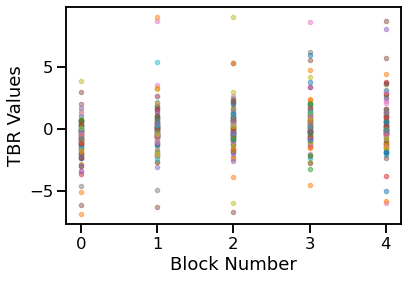

In [34]:
# Plot measured ratio values across blocks
for s_ind, data in enumerate(ratio_vals):
    plt.plot(data - np.mean(data), '.', alpha=0.5)
plt.xlabel('Block Number');
plt.ylabel(ratio + ' Values');

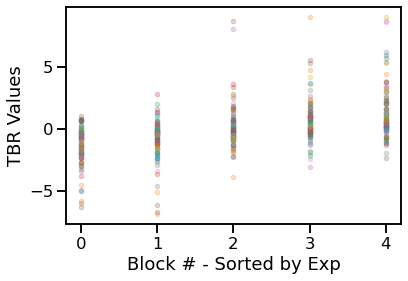

In [35]:
# Plot ratio values when blocks are sorted by parameter values
for s_ind, sort in enumerate(param_sort_inds):
    data = ratio_vals[s_ind, sort]
    plt.plot(data - np.mean(data), '.', alpha=0.25)
plt.xlabel('Block # - Sorted by ' + param);
plt.ylabel(ratio + ' Values');

In [36]:
# Create a copy the ratio values, sorted by the parameter value
sorted_ratio_vals = ratio_vals.copy()
for ind in range(n_subjs):
    sorted_ratio_vals[ind, :] = sorted_ratio_vals[ind, param_sort_inds[ind, :]]

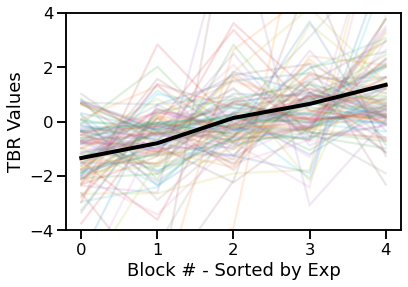

In [37]:
# Plot the per-subject ratio values, sorted by parameter, and the group average
for row in sorted_ratio_vals:
    plt.plot(row - np.mean(row), alpha=0.15)
    
avg = np.mean(sorted_ratio_vals, 0)
plt.plot(avg - np.mean(avg), 'k', lw=4)
plt.ylim([-4, 4]);
plt.xlabel('Block # - Sorted by ' + param);
plt.ylabel(ratio + ' Values');